__*Attribute Information:*__
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline

__*class:*__
- class_0
- class_1
- class_2

This is a copy of UCI ML Wine recognition datasets. https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine.

__*Original Owners:*__

Forina, M. et al, PARVUS - An Extendible Package for Data Exploration, Classification and Correlation. Institute of Pharmaceutical and Food Analysis and Technologies, Via Brigata Salerno, 16147 Genoa, Italy.

__*Citation:*__

Lichman, M. (2013). UCI Machine Learning Repository [https://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

__*References*__

(1) S. Aeberhard, D. Coomans and O. de Vel, Comparison of Classifiers in High Dimensional Settings, Tech. Rep. no. 92-02, (1992), Dept. of Computer Science and Dept. of Mathematics and Statistics, James Cook University of North Queensland. (Also submitted to Technometrics).

The data was used with many others for comparing various classifiers. The classes are separable, though only RDA has achieved 100% correct classification. (RDA : 100%, QDA 99.4%, LDA 98.9%, 1NN 96.1% (z-transformed data)) (All results using the leave-one-out technique)

(2) S. Aeberhard, D. Coomans and O. de Vel, “THE CLASSIFICATION PERFORMANCE OF RDA” Tech. Rep. no. 92-01, (1992), Dept. of Computer Science and Dept. of Mathematics and Statistics, James Cook University of North Queensland. (Also submitted to Journal of Chemometrics).

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Step 0. Data preparation

In [ ]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:,:2],
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Step 1. Preparing a neural network model

## Step 1.1. Model architecture

In [ ]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()

        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons,3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)

      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)

      return x


wine_net = WineNet(5)

## Step 1.2. Loss function

In [ ]:
loss = torch.nn.CrossEntropyLoss()


## Step 1.3. Optimizer

In [ ]:
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.01)

# Step 2. Training loop

In [ ]:
np.random.permutation(5)

array([2, 4, 0, 1, 3])

In [ ]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index: start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]

      pred = wine_net.forward(x_batch)

      loss_value = loss(pred, y_batch)

      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      print("TEST")
      print(test_preds)
      print((test_preds == y_test).float().mean())


TEST
tensor([1, 1, 2, 2, 0, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1,
        1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 2, 2, 1,
        0, 2, 0, 0, 1, 1])
tensor(0.9074)
TEST
tensor([1, 1, 2, 2, 0, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1,
        1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 2, 2, 1,
        0, 2, 0, 0, 1, 1])
tensor(0.9074)
TEST
tensor([1, 1, 2, 2, 0, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1,
        1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 2, 1, 0, 1, 2, 1, 0, 2, 2, 1,
        0, 2, 0, 0, 1, 1])
tensor(0.8704)
TEST
tensor([1, 1, 2, 2, 0, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1,
        1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 2, 2, 1,
        0, 2, 0, 0, 1, 1])
tensor(0.9074)
TEST
tensor([1, 1, 2, 2, 0, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1,
        1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 0, 1, 2, 1, 0, 2, 2, 1,
       

# Step 3. Visualization of dividing surfaces.

<ipython-input-49-4ffbf2cfa672>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train[indexes, 0],


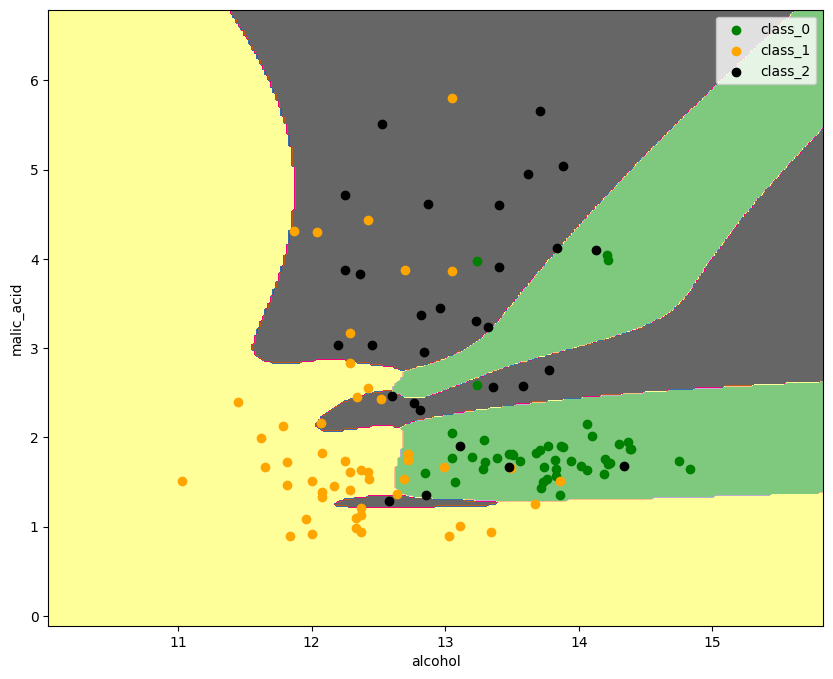

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0],
                X_train[indexes, 1],
                c=color,
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

# Step 4. Homework (60 points)

Let's practice with WineNet. Modify the architecture so that all 13 features are accepted as input and perform the following experiments:

1. Experiment with the number of neurons in the hidden layers. Try putting a very small number. Is there a threshold value for the number of hidden neurons at which learning becomes impossible?

2. Try passing different test_size values to the train_test_split function. At what value of test_size does the network predict worse than Base Rate*? And what is the Base Rate of the wine dataset?

3. Does the training time per epoch depend on the batch size? Explore this relationship.

As a report attach code and graphs that show all the necessary dependencies.

In [6]:
import torch
import random
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

#---- Start of Importing data ----------
wine = sklearn.datasets.load_wine()
wine.data.shape
#---- End Of Importing data ----------

# ----- Start of Model -------
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()

        self.fc1 = torch.nn.Linear(13, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons,3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)

      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)

      return x
# ----- End of Model -------

# Accepts number of hidden neurons, test sizes and batch sizes and runs experiments according given parameters

def experiment(n_hidden_neurons, test_size, batch_size):

  #Dividing into samples(Taking all 13 features)
  X_train, X_test, y_train, y_test = train_test_split(
      wine.data,
      wine.target,
      test_size=test_size,
      shuffle=True)

  X_train = torch.FloatTensor(X_train)
  X_test = torch.FloatTensor(X_test)
  y_train = torch.LongTensor(y_train)
  y_test = torch.LongTensor(y_test)

  wine_net = WineNet(n_hidden_neurons)

  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.01)

  times = []

  for epoch in range(5000):

      time_begin = time.time()

      order = np.random.permutation(len(X_train))
      for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index: start_index+batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        pred = wine_net.forward(x_batch)

        loss_value = loss(pred, y_batch)
        loss_value.backward()

        optimizer.step()

      duration = time.time() - time_begin
      times.append(duration)

  test_preds = wine_net.forward(X_test)
  test_preds = test_preds.argmax()
  accuracy = (test_preds == y_test).float().mean()

  return accuracy, times



EXPERIMENT 1

Changing the number of hidden layers.

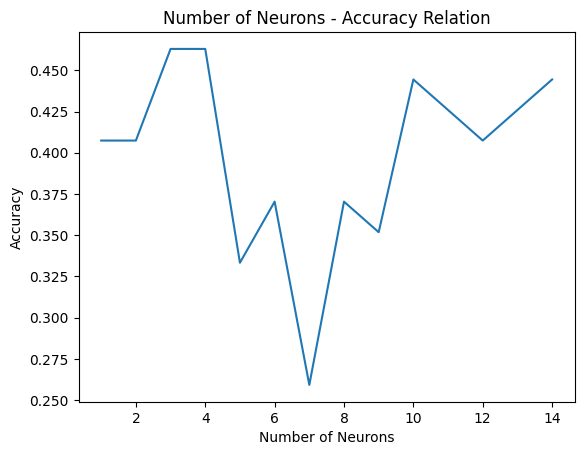

In [7]:
num_of_neurons = list(range(1, 15))
accuracies = []

for x in num_of_neurons:
    accuracy, _ = experiment(x, 0.3, 10)
    accuracies.append(accuracy)

plt.figure()
plt.plot(num_of_neurons, accuracies )
plt.xlabel('Number of Neurons')
plt.ylabel("Accuracy")
plt.title('Number of Neurons - Accuracy Relation')
plt.show()



There is a threshhold value when number of neurons is equal to 7

EXPERIMENT 2

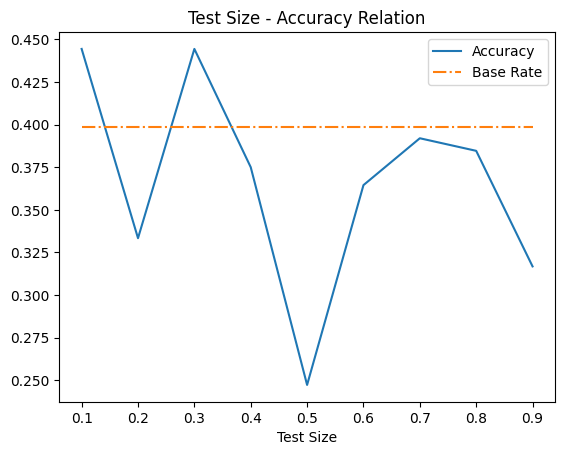

In [8]:

test_sizes = np.linspace(0.1, 0.9, num=9)

#--------Start of Counting Base Rate ----------
occurences = np.bincount(wine.target)
total_targets = len(wine.target)

base_rate = max(occurences) / total_targets
#--------End of Counting Base Rate ----------

Y_base_rate = [base_rate] * len(test_sizes)

accuracies = []
for test_sz in test_sizes:
    accuracy, _ = experiment(5, test_sz, 10)
    accuracies.append(accuracy)

plt.figure()
plt.plot(test_sizes, accuracies, label='Accuracy')
plt.plot(test_sizes, Y_base_rate, label='Base Rate', linestyle='-.')
plt.xlabel('Test Size')
plt.legend()
plt.title('Test Size - Accuracy Relation')
plt.show()



Base Rate is 40

EXPERIMENT 3

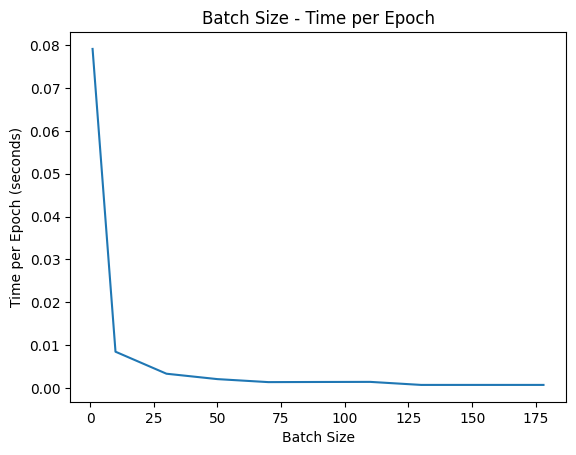

In [9]:
batch_sizes = [1, 10, 30, 50 , 70, 90, 110, 130, len(wine.data)]
Y_time = []

for bs in batch_sizes:
    _, times = experiment(5, 0.3, bs)
    np_times = np.array(times)
    Y_time.append(np_times.mean()) #Taking average of entire epoch times

plt.figure()
plt.plot(batch_sizes, Y_time)
plt.xlabel('Batch Size')
plt.ylabel('Time per Epoch (seconds)')
plt.title('Batch Size - Time per Epoch')
plt.show()

EXPERIMENT 3A

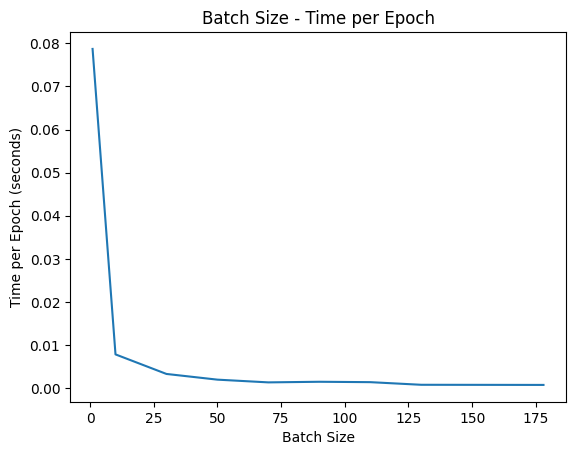

In [10]:
batch_sizes = [1, 10, 30, 50 , 70, 90, 110, 130, len(wine.data)]
Y_time = []

for bs in batch_sizes:
    _, times = experiment(5, 0.3, bs)
    Y_time.append(times[0]) #Taking only one duration from the epoch durations

plt.figure()
plt.plot(batch_sizes, Y_time)
plt.xlabel('Batch Size')
plt.ylabel('Time per Epoch (seconds)')
plt.title('Batch Size - Time per Epoch')
plt.show()